# Machine learning file

In this notebook, we are going to:
- analyse the data generated by the `data_preprocessing` file

- modify the analysed data for increased model performance

- create a pipeline for data splitting, training and testing

- have hyperparameter tuning on the different models to increase their respective performance

- create different functions to utilise the generated models

### Library imports

In [93]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

### Inputs imports

In [94]:
inputs = pd.read_csv("../Clean data/inputs.csv")

### Analyse inputs

In [95]:
inputs.head()

,Wiki ID,Freebase ID_x,Movie name,Release date_x,Revenue,Runtime,IMDb rating,Wins,Nominations,Release year_x,...,M-onehot_y,White_y,Black/African American_y,South Asian_y,East Asian_y,American Indian/Alaska Native_y,Arab/Middle East_y,Central and South Americans_y,Pacific Islander_y,Other_y
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.315268e+07,98.0,4.9,NaN,2.0,2001,...,1.0,0,1,0,0,0,0,0,0,0
1,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,5.8,NaN,NaN,1997,...,0.0,0,0,0,0,0,0,0,0,1
2,171005,/m/016ywb,Henry V,1989-11-08,2.398142e+07,137.0,7.5,12.0,13.0,1989,...,0.0,1,0,0,0,0,0,0,0,0
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,9.655040e+08,139.0,7.8,22.0,17.0,1964,...,1.0,0,0,0,0,0,0,0,0,1
4,156558,/m/014k4y,Baby Boy,2001-06-27,4.855272e+07,123.0,6.4,1.0,14.0,2001,...,0.0,0,1,0,0,0,0,0,0,0


In [96]:
inputs.shape

(10918, 130)

In [97]:
# Calculate the maximum value in the 'Revenue' column of the 'inputs' data
max_revenue = inputs['Revenue'].max()

# Calculate the minimum value in the 'Revenue' column of the 'inputs' data
min_revenue = inputs['Revenue'].min()

# Print the maximum revenue value
print("Maximum Revenue:", max_revenue)

# Print the minimum revenue value
print("Minimum Revenue:", min_revenue)

Maximum Revenue: 9522959437.465649
Minimum Revenue: 336.5110586513585


In [98]:
# DataFrame with revenues higher than 1'000'000'000
high_revenue_df = inputs[inputs['Revenue'] > 1000000000]

# DataFrame with revenues lower than 1'000
low_revenue_df = inputs[inputs['Revenue'] < 1000000]

In [99]:
high_revenue_df.shape

(99, 130)

In [100]:
low_revenue_df.shape

(952, 130)

Analysis on all inputs

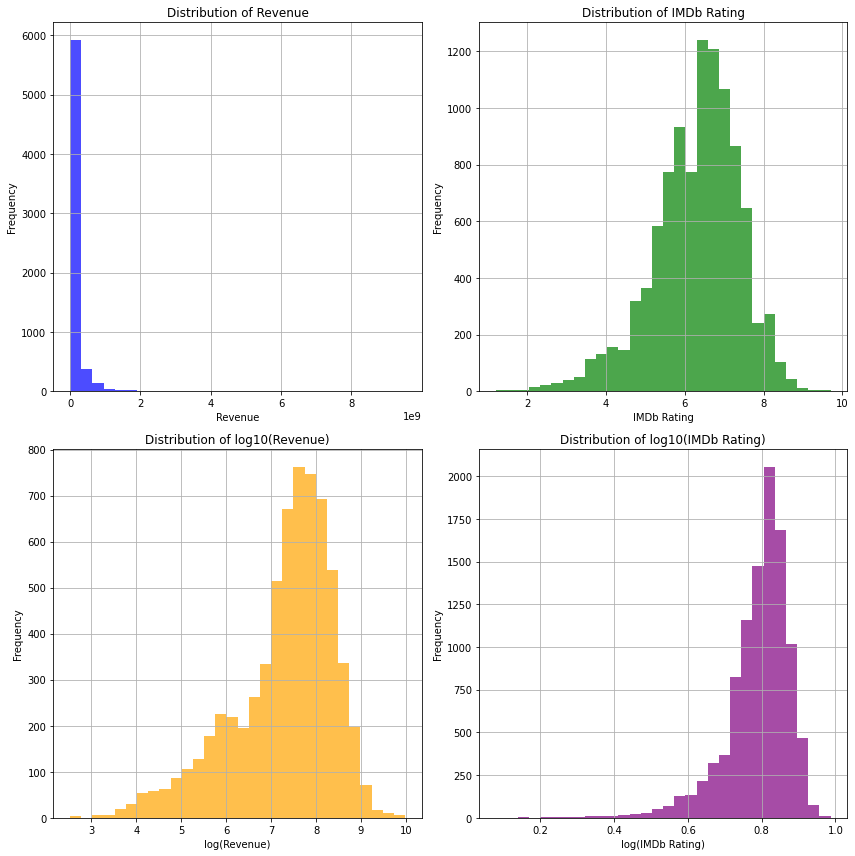

In [101]:
revenues = inputs['Revenue']
imdb_ratings = inputs['IMDb rating']

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot for Revenue
axes[0, 0].hist(revenues, bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of Revenue')
axes[0, 0].set_xlabel('Revenue')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for IMDb Rating
axes[0, 1].hist(imdb_ratings, bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of IMDb Rating')
axes[0, 1].set_xlabel('IMDb Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for log-transformed Revenue
axes[1, 0].hist(np.log10(revenues), bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of log10(Revenue)')
axes[1, 0].set_xlabel('log(Revenue)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Plot for log-transformed IMDb Rating
axes[1, 1].hist(np.log10(imdb_ratings), bins=30, alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of log10(IMDb Rating)')
axes[1, 1].set_xlabel('log(IMDb Rating)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.tight_layout() 
plt.show()


Analysis on inputs without the tail-end data

The goal is to great a more uniform data for model training

In [102]:
min_revenue_threshold = 100000  # Minimum revenue threshold
max_revenue_threshold = 1000000000  # Maximum revenue threshold

# Create a dataframe not including rows with 'Revenue' smaller than 100'000 and greater than 1'000'000'000
filtered_revenues_inputs = inputs[(inputs['Revenue'] > min_revenue_threshold) & (inputs['Revenue'] < max_revenue_threshold)]

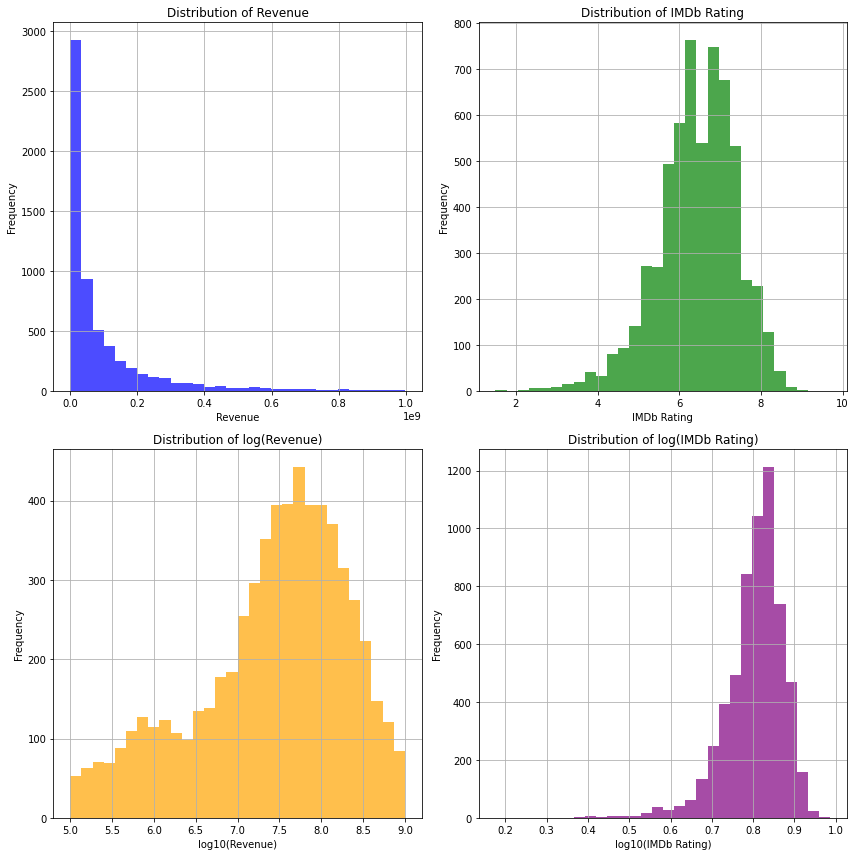

In [103]:
revenues = filtered_revenues_inputs['Revenue']
imdb_ratings = filtered_revenues_inputs['IMDb rating']

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot for Revenue
axes[0, 0].hist(revenues, bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of Revenue')
axes[0, 0].set_xlabel('Revenue')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for IMDb Rating
axes[0, 1].hist(imdb_ratings, bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of IMDb Rating')
axes[0, 1].set_xlabel('IMDb Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for log-transformed Revenue
axes[1, 0].hist(np.log10(revenues), bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of log(Revenue)')
axes[1, 0].set_xlabel('log10(Revenue)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Plot for log-transformed IMDb Rating
axes[1, 1].hist(np.log10(imdb_ratings), bins=30, alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of log(IMDb Rating)')
axes[1, 1].set_xlabel('log10(IMDb Rating)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.tight_layout()  # Adjusts the spacing between plots
plt.show()


Upon analysing this section, it becomes apparent that utilising the logarithm of `Revenue` tends to be more effective for training a model compared to using the raw `Revenue` values. Conversely, employing the actual `IMDb rating` rather than its logarithm appears to be more suitable. Additionally, there's potential value in considering the exclusion of "extreme" Revenues as an intriguing avenue to explore when training our models.

### Modelling functions and pipeline

In [104]:
# Function to create the 'features' and 'targets' for a `Revenue` model
def feat_and_target_revenue(data):
    feature = data.drop(['Revenue', 'IMDb rating'], axis = 1)
    target = np.log10(data['Revenue'])

    return feature, target

In [105]:
# Function to create the 'features' and 'targets' for a `Critics` model
def feat_and_target_critics(data):
    feature = data.drop(['IMDb rating', 'Revenue'], axis = 1)
    target = (data['IMDb rating'])

    return feature, target

In [106]:
# Function to split the data with 20% of data forming a 'test' data
def data_splitting(feature, target):
    #Returns x_train, x_test, y_train, y_test
    return train_test_split(feature, target, test_size=0.2, random_state=42) 

In [107]:
# Defines a function to fit and evaluate different models based on the provided parameters
def fit_model_revenue(model_name, xtrain, xtest, ytrain, ytest):
    # Selects the appropriate regression model based on the given model name
    if model_name == 'RandomForest':
        model = RandomForestRegressor(
            max_depth=13,
            max_features=0.5044385141334264,
            min_samples_leaf=4,
            min_samples_split=15,
            n_estimators=140,
            random_state=42
        )  # Hyperparameters obtained for 'RandomForest' to predict 'Revenue'
    elif model_name == 'XGB':
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            colsample_bytree=0.5382140919340437,
            gamma=1.0628444205682614,
            max_depth=7,
            min_child_weight=1,
            n_estimators=70,
            reg_alpha=40
        )  # Hyperparameters obtained for 'XGB'
    elif model_name == 'GBM':
        model = GradientBoostingRegressor(
            learning_rate=0.048040737541705625,
            max_depth=4,
            min_samples_leaf=8,
            min_samples_split=5,
            n_estimators=200,
            subsample=0.7977456176958748,
            random_state=42
        )  # Hyperparameters obtained for 'GBM'
    else:
        # Handles invalid model names
        print("Invalid model name.")
        return
    
    # Trains the selected model
    model.fit(xtrain, ytrain)
    
    # Predicts on test data and evaluates the model
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    print("RMSE:", math.sqrt(mse))
    variance = ytest.std()
    print("Std:", variance)
    errors = abs(ytest - ypred)
    mean_error = np.mean(errors)
    print("Mean Absolut Error:", mean_error)

    # Plots distribution of predictions and "real" values
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].hist(ypred, bins=30, alpha=0.7, color='blue')
    axes[0].set_title('Distribution of Predictions')
    axes[0].set_xlabel('Revenues')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    axes[1].hist(ytest, bins=30, alpha=0.7, color='red')
    axes[1].set_title('Distribution of Actual Values')
    axes[1].set_xlabel('Revenues')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

    # Saves the trained model if it's RandomForest, XGB, or GBM
    if model_name in ['RandomForest', 'XGB', 'GBM']:
        joblib.dump(model, f'{model_name}_revenue_model.pkl')
        print(f"{model_name} model trained and saved.")


In [108]:
# Defines a function to fit and evaluate different models based on the provided parameters
def fit_model_critics(model_name, xtrain, xtest, ytrain, ytest):
    # Selects the appropriate regression model based on the given model name
    if model_name == 'RandomForest':
        model = RandomForestRegressor(
    max_depth=17,
    max_features=0.5013884710633058,
    min_samples_leaf=9,
    min_samples_split=14,
    n_estimators=110,
    random_state=42
)  # Hyperparameters obtained for 'RandomForest' to predict 'IMDb rating' (aka Critics)
    elif model_name == 'XGB':
        model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree = 0.8040762773750969, 
    gamma = 0.014551544273050691,
    max_depth = 7, 
    min_child_weight = 1.8067173676269164, 
    n_estimators = 200, 
    reg_alpha = 0.28332090854937586
)  # Hyperparameters obtained for 'XGB' to predict 'IMDb rating' (aka Critics)
    elif model_name == 'GBM':
        model = GradientBoostingRegressor(
    learning_rate=0.058359413134240305,
    max_depth=4,
    min_samples_leaf=10,
    min_samples_split=2,
    n_estimators=150,
    subsample=0.6268043574324423,
    random_state=42
)   # Hyperparameters obtained for 'GBM' to predict 'IMDb rating' (aka Critics)
    else:
        # Handles invalid model names
        print("Invalid model name.")
        return
    # Predicts on test data and evaluates the model
    model.fit(xtrain, ytrain)
    
    # Predicts on test data and evaluates the model
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    print("RMSE:", math.sqrt(mse))
    variance = ytest.std()
    print("Std:", variance)
    errors = abs(ytest - ypred)
    mean_error = np.mean(errors)
    print("Mean Absolut Error:", mean_error)

    # Plots distribution of predictions and "real" values
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].hist(ypred, bins=30, alpha=0.7, color='blue')
    axes[0].set_title('Distribution of Predictions')
    axes[0].set_xlabel('Predictions')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    axes[1].hist(ytest, bins=30, alpha=0.7, color='red')
    axes[1].set_title('Distribution of Actual Values')
    axes[1].set_xlabel('Values')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    # Saves the trained model if it's RandomForest, XGB, or GBM
    if model_name in ['RandomForest', 'XGB', 'GBM']:
        joblib.dump(model, f'{model_name}_critics_model.pkl')
        print(f"{model_name} model trained and saved.")

In [109]:
# Pipeline for 'Revenue' model prediction
def pipeline_revenue(data, model_name):
    feature, target = feat_and_target_revenue(data)
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    fit_model_revenue(model_name, xtrain, xtest, ytrain, ytest)

# Pipleine for 'IMDb rating' model prediction    
def pipeline_critics(data, model_name):
    feature, target = feat_and_target_critics(data)
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    fit_model_critics(model_name, xtrain, xtest, ytrain, ytest)

#'XGB': Refers to the XGBoostRegressor model.
#'RandomForest': Refers to the RandomForestRegressor model from scikit-learn.
#'GBM': Refers to the GradientBoostingRegressor model from scikit-learn.

### Inputs modification for pipeline use

In [110]:
# Create a list of columns to keep for model pipelines
# Targets
to_keep = ['Revenue', 'IMDb rating',
# Movie nurmerical features    
'Runtime', 'Release year_x', 
# Language categorical feature
'English Language-onehot','Tamil Language-onehot', 'Hindi Language-onehot','Malayalam Language-onehot', 'German Language-onehot','Japanese Language-onehot', 'Korean Language-onehot','Spanish Language-onehot', 'Italian Language-onehot','French Language-onehot', 'Standard Mandarin-onehot','Standard Cantonese-onehot', 'Bengali Language-onehot','Cantonese-onehot', 'Telugu language-onehot', 'Russian Language-onehot','Portuguese Language-onehot', 'Urdu Language-onehot','Arabic Language-onehot', 'Tagalog language-onehot','Swedish Language-onehot', 
# Country categorical feature
'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 
# Genre categorical feature
'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-onehot',
# Primary actor numerical features
'Actor height_x', 'Actor age at release_x',
# Primary actor gender categorical feature
'F-onehot_x','M-onehot_x',
# Primary actor ethnicity categorical feature
'White_x', 'Black/African American_x', 'South Asian_x', 'East Asian_x', 'American Indian/Alaska Native_x', 'Pacific Islander_x', 'Arab/Middle East_x', 'Central and South Americans_x', 'Other_x',
# Secondary actor numerical features
'Actor height_y', 'Actor age at release_y',
# Secondary actor gender categorical feature
'F-onehot_y', 'M-onehot_y',
# Secondary actor ethnicity categorical feature
'White_y', 'Black/African American_y', 'South Asian_y', 'East Asian_y', 'American Indian/Alaska Native_y', 'Pacific Islander_y', 'Arab/Middle East_y', 'Central and South Americans_y', 'Other_y']


all_inputs = inputs[to_keep]
# Inputs with "extreme" 'revenues' excluded. This is the data that has been used to train our models. 'all_inputs' also presented great results but 'inputs_filt' presented favorable results.
inputs_filt = filtered_revenues_inputs[to_keep]

# NaN must be dropped for our models to train 
all_inputs = all_inputs.dropna()
inputs_filt = inputs_filt.dropna()

# Data taken out of 'inputs_filt' to play with later in the code
play_data = inputs_filt.head(200)
# Get rid of the play data as we don't want to play with data which has been used for training
inputs_filt = inputs_filt[200:]

print(all_inputs.shape)
print(inputs_filt.shape)

(4753, 92)
(4304, 92)


In [111]:
### Using pipelines

RMSE: 0.8376277013531883
Std: 0.9404077690058666
Mean Absolut Error: 0.6456295297246261


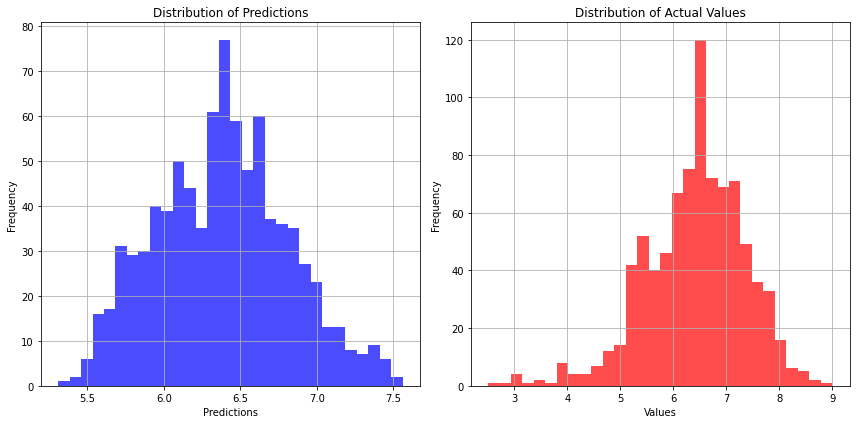

RandomForest model trained and saved.
RMSE: 0.911481979311242
Std: 0.9404077690058666
Mean Absolut Error: 0.7047946614255473


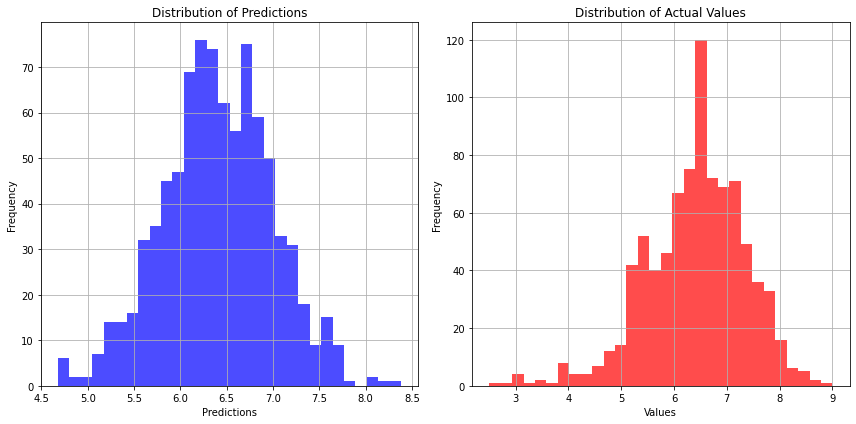

XGB model trained and saved.
RMSE: 0.8451266641844211
Std: 0.9404077690058666
Mean Absolut Error: 0.6515248738786907


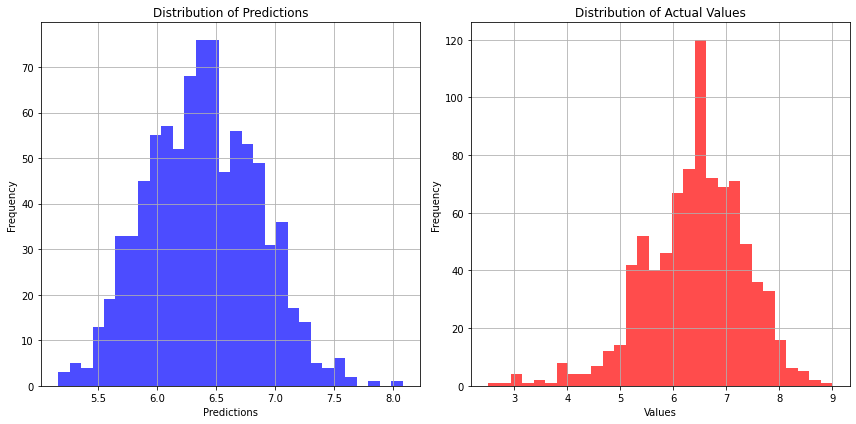

GBM model trained and saved.
RMSE: 0.701599175543441
Std: 0.8738595660816861
Mean Absolut Error: 0.537931260873465


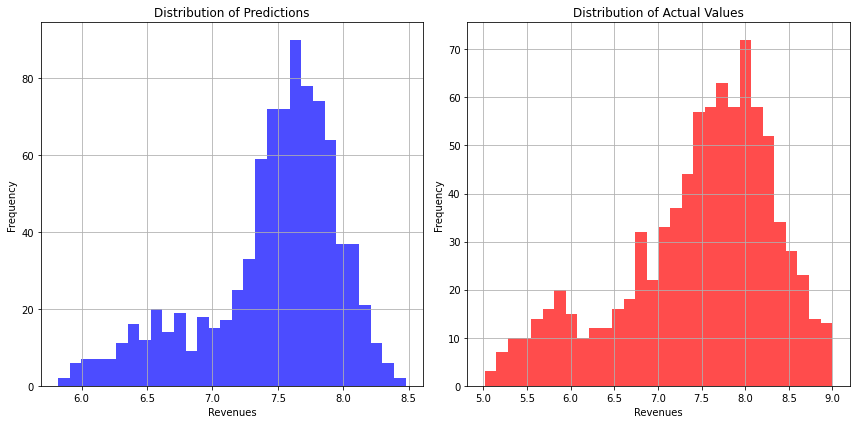

RandomForest model trained and saved.
RMSE: 0.7105091569192131
Std: 0.8738595660816861
Mean Absolut Error: 0.5528480690231017


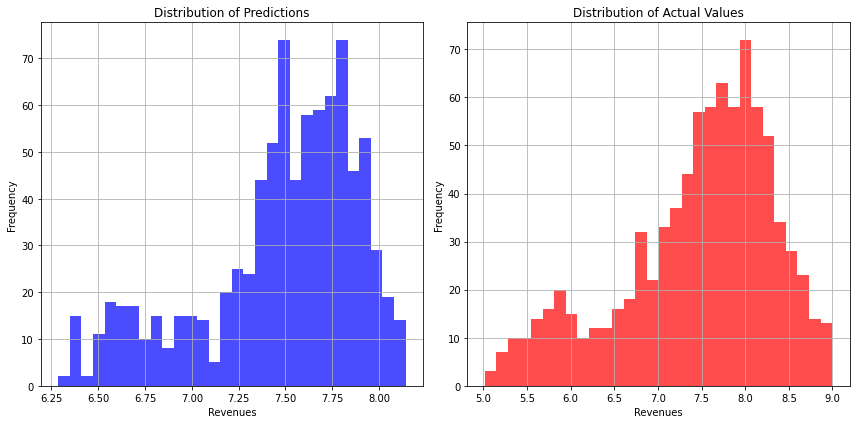

XGB model trained and saved.
RMSE: 0.6999885141333914
Std: 0.8738595660816861
Mean Absolut Error: 0.5335267356182384


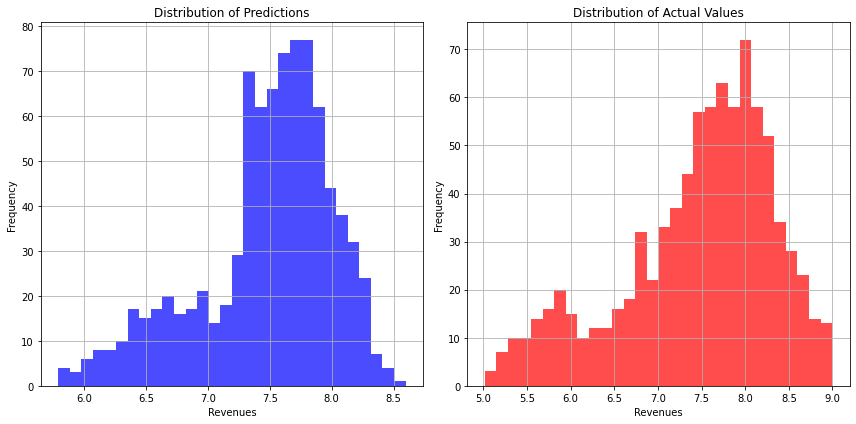

GBM model trained and saved.


In [112]:
pipeline_critics(inputs_filt, 'RandomForest')
pipeline_critics(inputs_filt, 'XGB')
pipeline_critics(inputs_filt, 'GBM')

pipeline_revenue(inputs_filt, 'RandomForest')
pipeline_revenue(inputs_filt, 'XGB')
pipeline_revenue(inputs_filt, 'GBM')

Through the RMSE and a visual analysis of the of the distributions (similar distributions for the predictions and actual values is a good sign), we can pick a model for the prediction of 'Revenue' and 'IMDb rating'. Hence, we can pick 'RandomForest' for 'IMDb rating' prediction and 'GBM' for 'Revenue' prediction.

### Hyperparameter tuning

The obtained hyperparameters from this code is then implemented in the 'fit_model_critics' and 'fit_model_revenue' functions according to the model and the prediction type ('Revenue' vs 'IMDb rating').

In [113]:
# GBM tested hyperparameters through tuning
space_GBM = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

In [114]:
# RandomForest tested hyperparameters through tuning
space_RandomForest = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.uniform('max_features', 0.5, 1)
}

In [115]:
# XGB tested hyperparameters through tuning
space_XGB = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5)
}


In [116]:
# Define a function for hyperparameter tuning based on different algorithms and goals
def hyperopt_tuning(algo_type, space, data, goal):
    # Determine feature and target based on the specified goal ('Revenue' or 'Critics')
    if goal == 'Revenue':
        feature, target = feat_and_target_revenue(data)
    elif goal == 'Critics':
        feature, target = feat_and_target_critics(data)
    else:
        raise ValueError("Goal not understood")
    
    # Split the data into training and testing sets
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    
    # Define an objective function for hyperparameter optimization
    def objective(space):
        # Choose the regressor based on the specified algorithm type
        if algo_type == 'XGB':
            clf = xgb.XGBRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                learning_rate=space['learning_rate'],
                subsample=space['subsample'],
                colsample_bytree=space['colsample_bytree'],
                gamma=space['gamma'],
                min_child_weight=space['min_child_weight'],
                reg_alpha=space['reg_alpha'],
                reg_lambda=space['reg_lambda']
            )
        elif algo_type == 'GBM':
            clf = GradientBoostingRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                learning_rate=space['learning_rate'],
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                subsample=space['subsample'],
                random_state=42
            )
        elif algo_type == 'RandomForest':
            clf = RandomForestRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                max_features=space['max_features'],
                random_state=42
            )
        else:
            raise ValueError("Invalid algorithm type. Supported types are 'XGB', 'GBM', 'RandomForest'")
        
        # Set up cross-validation and calculate mean squared error for optimization
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error')
        mean_mse = np.mean(-mse_scores)
        
        return {'loss': mean_mse, 'status': STATUS_OK}
    
    trials = Trials()  # Initialize trials for hyperparameter optimization

    # Execute hyperparameter optimization using fmin function from hyperopt
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=80,
                            trials=trials)

    # Print information about each trial's hyperparameters and scores
    for i, result in enumerate(trials.results):
        hyperparameters = trials.trials[i]['misc']['vals']
        score = result['loss']
        print(f"Trial {i+1}: Hyperparameters - {hyperparameters}, Score - {score}")

    return best_hyperparams, trials  # Return the best hyperparameters and the trials


In [117]:
best_hyperparams, _ = hyperopt_tuning('XGB', space_XGB, inputs_filt, 'Critics')
print("The best hyperparameters are: ", best_hyperparams)

  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

 15%|█▌        | 12/80 [01:21<07:39,  6.76s/trial, best loss: 0.7010475082915899]


KeyboardInterrupt: 

### Use models (fun part)

In [118]:
# Defines a function to utilize pre-trained models for critics' ratings prediction
def use_models_critics(data, model):
    # Extracts real IMDb ratings from the dataset
    real_ratings = data['IMDb rating']
    real_ratings = real_ratings.to_list()

    # Removes 'IMDb rating' and 'Revenue' columns from the dataset
    data = data.drop(['IMDb rating', 'Revenue'], axis=1)

    # Loads the specified pre-trained model based on the input model type
    if model == 'RandomForest':
        loaded_model = joblib.load('RandomForest_critics_model.pkl')
    elif model == 'XGB':
        loaded_model = joblib.load('XGB_critics_model.pkl')
    elif model == 'GBM':
        loaded_model = joblib.load('GBM_critics_model.pkl')
    else:
        raise ValueError("Invalid model type")

    # Predicts unseen data using the loaded model
    unseen_data_predictions = loaded_model.predict(data)
    
    # Calculates the absolute element-wise difference between real and predicted ratings
    abs_element_wise_difference = [abs(x - y) for x, y in zip(real_ratings, unseen_data_predictions)]
    print("List of 200 elements absolute error =", abs_element_wise_difference)
    
    # Computes the mean of the absolute differences
    list_mean = sum(abs_element_wise_difference) / len(abs_element_wise_difference)
    print("Absolute mean error =", list_mean)


In [119]:
# Defines a function to employ pre-trained models for revenue prediction
def use_models_revenue(data, model):
    # Extracts real Revenue values from the dataset
    real_revenue = data['Revenue']
    real_revenue = real_revenue.to_list()

    # Removes 'IMDb rating' and 'Revenue' columns from the dataset
    data = data.drop(['IMDb rating', 'Revenue'], axis=1)

    # Loads the specified pre-trained model based on the input model type
    if model == 'RandomForest':
        loaded_model = joblib.load('RandomForest_revenue_model.pkl')
    elif model == 'XGB':
        loaded_model = joblib.load('XGB_revenue_model.pkl')
    elif model == 'GBM':
        loaded_model = joblib.load('GBM_revenue_model.pkl')
    else:
        raise ValueError("Invalid model type")

    # Predicts unseen data using the loaded model and adjusts predictions using log10 transformation
    unseen_data_predictions = np.power(10, loaded_model.predict(data))
    
    # Calculates the absolute element-wise difference between real and predicted revenues
    abs_element_wise_difference = [abs(x - y) for x, y in zip(real_revenue, unseen_data_predictions)]
    print("List of 200 elements absolute error =", abs_element_wise_difference)
    
    # Computes the mean of the absolute differences
    list_mean = sum(abs_element_wise_difference) / len(abs_element_wise_difference)
    print("Absolute mean error =", list_mean)

In [120]:
use_models_critics(play_data, 'RandomForest')

List of 200 elements absolute error = [0.8833028251444244, 0.29383499775291533, 0.5115743275229709, 0.8046714993530548, 0.1553023381125147, 0.825610968386898, 0.7214280490034932, 0.5482980867337073, 0.34524043019579764, 0.47358953793028924, 0.29802515875083824, 0.44665256903114336, 0.6225423070747347, 0.26453356324410304, 1.7798233239451138, 0.08609196884014558, 0.44754365653278594, 0.14910357701525356, 0.9725660630069983, 0.024511783765042594, 0.11521948751998501, 0.028077055825756148, 0.32570740419768995, 0.7832138885958981, 0.5312312760530471, 1.1317207846456405, 0.24093680696397435, 0.05316725871048256, 1.422858394075437, 0.43707613352694086, 1.1920778513629164, 0.7177046975572123, 2.263723777351135, 0.3166277381085205, 0.199725871047006, 0.3289746953438639, 0.062049664683371475, 0.7129088210118972, 0.788353959190129, 0.92880029904663, 0.28337762540185896, 1.4356544530025435, 0.667515668227125, 0.9533527603340106, 0.6694644533530667, 0.5315918674911275, 0.8237175063202349, 0.438672

In [121]:
use_models_critics(play_data, 'XGB')

List of 200 elements absolute error = [1.0968914985656735, 0.038744449615478516, 0.16033182144165004, 0.8636406898498539, 0.12442302703857422, 0.45479335784912145, 1.1940722465515137, 0.42432012557983434, 0.33993358612060565, 0.7344702720642093, 0.018166065216064453, 0.4096956253051758, 0.28064870834350586, 0.13276023864746112, 1.4656377792358395, 0.23141126632690412, 0.15664987564086896, 0.8441472053527832, 1.2301475524902346, 0.039310455322265625, 0.054577445983886363, 0.06894207000732422, 0.46316404342651385, 0.26064100265502965, 0.3133844375610355, 0.6740550041198734, 0.6103434562683105, 0.11776227951049822, 1.5669347763061525, 0.6623302459716793, 0.8400075912475584, 0.7144887924194334, 1.5837877273559569, 0.2052174568176266, 0.33651809692382795, 0.432660388946533, 0.45250787734985387, 0.8200442314147951, 0.40704774856567383, 0.8139722824096678, 0.3098746299743649, 1.7658085823059082, 0.9073220252990719, 0.9616646766662598, 1.1397976875305176, 0.0037701606750486505, 0.7114691734313

In [122]:
use_models_critics(play_data, 'GBM')

List of 200 elements absolute error = [0.7774208297495342, 0.28870274851771693, 0.43673069342952253, 0.7542591074570346, 0.06608406384046628, 0.8696703693104526, 0.6757214219596062, 0.5411924482299897, 0.38245125513405664, 0.2743330082805713, 0.2677761767566489, 0.508289490290454, 0.23439449503554588, 0.3504912291950131, 1.5384773264290255, 0.12622056906750778, 0.2618614201833145, 0.030593233222467653, 1.003163006480908, 0.06737974940196789, 0.2575902186726591, 0.24690493874626096, 0.1339330085096213, 0.4587674072883443, 0.20798707071354183, 1.1061594184306491, 0.28268685236969215, 0.04810427071323353, 1.1076956273646585, 0.5049893475342513, 1.1703613952230336, 0.6219515221833518, 2.3442391528996342, 0.34987012001596085, 0.2369335778175552, 0.07935206692642272, 0.3483028797054235, 0.6087523963444266, 0.6583303323551046, 1.100894699157732, 0.06975031797756781, 1.6764086983035238, 0.5704235440646412, 0.984187943408525, 0.3762207182070707, 0.49281613907265864, 0.6680298922644692, 0.318711

In [123]:
use_models_revenue(play_data, 'RandomForest')

List of 200 elements absolute error = [51091155.47754179, 19340346.95473936, 16977775.010403395, 2577786.4347855127, 32001657.99565149, 72451.86380632967, 1816991.2229991131, 58622060.24775402, 5206679.586801147, 24731917.060015537, 44306953.17693224, 42105007.839982055, 117690639.79786032, 19787226.1137942, 2177776.368850318, 22059341.16833651, 182831044.22297895, 6436348.717971647, 40011369.720443256, 193417479.9516911, 711848.7951217368, 22159605.884831183, 7683843.468800471, 39222571.154799804, 12025415.708939753, 16388205.361665316, 20279634.573698346, 11072250.442105316, 8791833.178207453, 48162215.89729273, 62070078.25235903, 89436735.11121988, 1051070.5098228292, 144234928.43648365, 61951270.75236476, 119264.76823735517, 308335.68792240834, 632512094.0611798, 108181340.70771237, 32317585.720327694, 9112532.172584524, 22090664.06903801, 13730470.297044765, 3712967.5601419844, 75971778.40588395, 611969908.8562765, 28149865.849200953, 5600098.076919153, 82201218.41347787, 2546237.

In [124]:
use_models_revenue(play_data, 'XGB')

List of 200 elements absolute error = [31585253.67950311, 5777450.805201609, 8606749.264285713, 2930639.345114087, 30853597.208185486, 4060145.2597864717, 2531035.4398369566, 82967878.18181819, 331918.68107639067, 32377245.687407404, 41988729.48062621, 50812248.07058824, 129159512.68711653, 15776574.691619936, 3194273.9580730544, 1887196.0611600578, 173922481.6963471, 3374092.497184608, 32486969.11866042, 185744698.02250335, 2193877.5000440143, 6938859.564675754, 6853912.638878266, 60840821.58935484, 2655774.0080392137, 7660845.841753781, 16729716.408823527, 6799983.856115095, 9591851.73283754, 29353429.21095818, 79148482.56338583, 80822220.79317698, 2721698.993155027, 137925977.3937601, 75248899.65932132, 1191692.8432930708, 1275243.6127329194, 625491341.7548473, 107174359.25968844, 35471772.34760125, 27418652.43445693, 24510489.079365082, 14166088.358918006, 1507889.3922913, 84727132.51748171, 582609590.7096773, 23303109.04093866, 13746288.413793106, 83868377.69463924, 935233.8791576

In [125]:
use_models_revenue(play_data, 'GBM')

List of 200 elements absolute error = [58472128.30018474, 1782084.5019865409, 3626293.8161791563, 1306776.5295232378, 31224269.256188363, 551602.1601265073, 1957852.136710409, 57496689.52002999, 659971.9929194264, 34526980.074007474, 42038294.41254663, 28367419.210058585, 35953041.851714134, 18580798.13880705, 1042277.0073610841, 5655754.715062879, 190348588.5429644, 9785561.525130684, 56943628.66676615, 192753232.42371622, 5834005.862947375, 13333695.207707236, 5121888.022983006, 31119049.925657302, 6935313.579891086, 443817.9009823501, 7504493.976713702, 7389167.642534189, 1944243.5937744826, 34511478.062327996, 82707124.16277541, 86167354.28431582, 1021689.9471396465, 146026599.8114639, 43775642.694429986, 495024.20394607005, 364106.6733397213, 639092788.4453748, 134622025.3939843, 24499982.108276233, 14797862.593987817, 29433702.88753864, 10492343.892616544, 4204147.666326281, 77729844.45682079, 586250854.3259501, 20198381.037720364, 9780818.020177785, 83127137.16431387, 1240727.86

For clarification, the absolute mean error for the 'IMDb rating' and 'Revenue' are close to our expectations. Indeed the 'IMDb rating' mean absolute error can be obvious when looking at our model training. However the 'Revenue' absolute error can be more subtile to understand: the AME is so high because is represents both error from movies where the 'Revenue' is of magnitude 10^8. However, it does not mean that the error for movies with the magnitude of 10^5 is the same. The error is proportionnal to the magnitude of the 'Revenue'. Hence a movie with an actual 'Revenue' of 700'000'000 can be predicted to 800'000'000 but a movie with an actual 'Revenue' of 700'000 can be predicted to 800'000 (this is just an example).

In [126]:
# Function to initialise a dataframe of 0 for every colum (wanted for further model playing)
def create_zero_dataframe(columns_list):
    data = {col: [0] * num_rows for col in columns_list}
    return pd.DataFrame(data)

# List of features used in the models
columns =  [
# Movie nurmerical features   
'Runtime', 'Release year_x', 
# Language categorical feature
'English Language-onehot','Tamil Language-onehot', 'Hindi Language-onehot','Malayalam Language-onehot', 'German Language-onehot','Japanese Language-onehot', 'Korean Language-onehot','Spanish Language-onehot', 'Italian Language-onehot','French Language-onehot', 'Standard Mandarin-onehot','Standard Cantonese-onehot', 'Bengali Language-onehot','Cantonese-onehot', 'Telugu language-onehot', 'Russian Language-onehot','Portuguese Language-onehot', 'Urdu Language-onehot','Arabic Language-onehot', 'Tagalog language-onehot','Swedish Language-onehot', 
# Country categorical feature
'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 
# Genre categorical feature
'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-onehot',
# Primary actor numerical features
'Actor height_x', 'Actor age at release_x',
# Primary actor gender categorical feature
'F-onehot_x','M-onehot_x',
# Primary actor ethnicity categorical feature
'White_x', 'Black/African American_x', 'South Asian_x', 'East Asian_x', 'American Indian/Alaska Native_x', 'Pacific Islander_x', 'Arab/Middle East_x', 'Central and South Americans_x', 'Other_x',
# Secondary actor numerical features
'Actor height_y', 'Actor age at release_y',
# Secondary actor gender categorical feature
'F-onehot_y', 'M-onehot_y',
# Secondary actor ethnicity categorical feature
'White_y', 'Black/African American_y', 'South Asian_y', 'East Asian_y', 'American Indian/Alaska Native_y', 'Pacific Islander_y', 'Arab/Middle East_y', 'Central and South Americans_y', 'Other_y'] # Replace this with your list of columns

# Creates one row to play with a singular made-up movie
num_rows = 1

# Create the dataframe (zero_df is just a name, it will eventually be filled with made-up information)
zero_df = create_zero_dataframe(columns)
zero_df


,Runtime,Release year_x,English Language-onehot,Tamil Language-onehot,Hindi Language-onehot,Malayalam Language-onehot,German Language-onehot,Japanese Language-onehot,Korean Language-onehot,Spanish Language-onehot,...,M-onehot_y,White_y,Black/African American_y,South Asian_y,East Asian_y,American Indian/Alaska Native_y,Pacific Islander_y,Arab/Middle East_y,Central and South Americans_y,Other_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


WARNING : The more unlikely the movie (ex: a Spanish, Korean collaboration with Afro/American protagonists released in 1940 with characters speaking Mandarin), the less robust the models are as you are testing never seen-type of data

In [127]:
# Made-up movie features (can be changed for fun)
Runtime = 110
Release_year = 2007
Languages= ['English']
Countries = ['United States of America', 'United Kingdom']
Genres = ['Thriller', 'Science Fiction']
Primary_actor_height = 140
Primary_actor_age = 42
Primary_actor_gender = 'M'
Primary_actor_ethnicity = 'Arab/Middle East'
Secondary_actor_height = 180
Secondary_actor_age = 18
Secondary_actor_gender = 'F'
Secondary_actor_ethnicity = 'Black/African American'

In [128]:
# The differents features introduced above are entered in 'zero_df' through different ways according to their nature
# Runtime
zero_df['Runtime'] = Runtime
# Release year
zero_df['Release year_x'] = Release_year
# Languages (one movie can have multiple languages)
for lang in Languages:
    lang_column = f'{lang} Language-onehot'
    if lang_column in zero_df.columns:
        zero_df[lang_column] = 1
# Countries (one movie can have multipe countries of production)
for country in Countries:
    country_column = f'{country}-onehot'
    if country_column in zero_df.columns:
        zero_df[country_column] = 1
# Genres (one movie can have multiple genres)
for genre in Genres:
    genre_column = f'{genre}-onehot'
    if genre_column in zero_df.columns:
        zero_df[genre_column] = 1
# Primary actor height
zero_df['Actor height_x'] = Primary_actor_height
# Primary actor age at release
zero_df['Actor age at release_x'] = Primary_actor_age
# Primary actor gender
if Primary_actor_gender == 'M':
    zero_df['M-onehot_x'] = 1
else:
    zero_df['F-onehot_x'] = 1
# Primary actor ethnicity
ethni = f'{Primary_actor_ethnicity}_x'
if ethni in zero_df.columns:
    zero_df[ethni] = 1
# Secondary actor height
zero_df['Actor height_y'] = Secondary_actor_height
# Secondary actor age at release
zero_df['Actor age at release_y'] = Secondary_actor_age
# Secondary actor gender
if Secondary_actor_gender == 'M':
    zero_df['M-onehot_y'] = 1
else:
    zero_df['F-onehot_y'] = 1
# Secondary actor ethnicity
ethni = f'{Secondary_actor_ethnicity}_y'
if ethni in zero_df.columns:
    zero_df[ethni] = 1

In [129]:
# Funtion to generate a 'Revenue' prediction on a chosen data and model
def play_models_revenue(data, model):
    if model == 'RandomForest':
        loaded_model = joblib.load('RandomForest_revenue_model.pkl')
    elif model == 'XGB':
        loaded_model = joblib.load('XGB_revenue_model.pkl')
    elif model == 'GBM':
        loaded_model = joblib.load('GBM_revenue_model.pkl')
    else:
        raise ValueError("Invalid model type")
    #Returns the power10(result) to restablish 'Revenue' in not log10 value
    unseen_data_predictions = np.power(10, loaded_model.predict(data))
    return unseen_data_predictions

In [130]:
# Function to generate a 'IMDb rating' prediction on a chosen data and model
def play_models_critics(data, model):
    if model == 'RandomForest':
        loaded_model = joblib.load('RandomForest_critics_model.pkl')
    elif model == 'XGB':
        loaded_model = joblib.load('XGB_critics_model.pkl')
    elif model == 'GBM':
        loaded_model = joblib.load('GBM_critics_model.pkl')
    else:
        raise ValueError("Invalid model type")

    unseen_data_predictions = loaded_model.predict(data)
    return unseen_data_predictions

In [131]:
# Use 'RandomForest' for 'IMDb rating' prediction
predicted_revenue = play_models_critics(zero_df, 'RandomForest')
print(predicted_revenue)

[6.23631949]


In [132]:
# Use 'GBM' for 'Revenue' prediction
predicted_critics = play_models_revenue(zero_df, 'GBM')
print(predicted_critics)

[37206940.44666026]


In [133]:
# Function to predict optimal of multiple missing features to achieve a goal 'IMDb rating'
# 'num_samples' is the chosen resolution for the function
# the function complexity is the following: num_samples^number_of_features_to_optimise
def find_optimal_configuration_for_score(goal_score, model, data, features_to_predict, num_samples=10):
    closest_configuration = None
    closest_score_difference = float('inf')  # Initialize with a large value
    closest_score_achieved = None

    feature_ranges = {
        # Numerical features + Actors gender
        'Runtime': [30, 300],  # Example range for runtime values
        'Release year_x': [1913, 2010],
        'Actor height_x': [0.5, 2.5],
        'Actor age at release_x': [18, 100],
        'Actor height_y': [0.5, 2.5],
        'Actor age at release_y': [18, 100],
        'M-onehot_x' : [0,1],
        'M-onehot_y' : [0,1],
           # Languages
        'English Language-onehot': [0, 1],
        'Tamil Language-onehot': [0, 1],
        'Hindi Language-onehot': [0, 1],
        'Malayalam Language-onehot': [0, 1],
        'German Language-onehot': [0, 1],
        'Japanese Language-onehot': [0, 1],
        'Korean Language-onehot': [0, 1],
        'Spanish Language-onehot': [0, 1],
        'Italian Language-onehot': [0, 1],
        'French Language-onehot': [0, 1],
        'Standard Mandarin-onehot': [0, 1],
        'Standard Cantonese-onehot': [0, 1],
        'Bengali Language-onehot': [0, 1],
        'Cantonese-onehot': [0, 1],
        'Telugu language-onehot': [0, 1],
        'Russian Language-onehot': [0, 1],
        'Portuguese Language-onehot': [0, 1],
        'Urdu Language-onehot': [0, 1],
        'Arabic Language-onehot': [0, 1],
        'Tagalog language-onehot': [0, 1],
        'Swedish Language-onehot': [0, 1],
        # Countries
        'United States of America-onehot': [0, 1],
        'United Kingdom-onehot': [0, 1],
        'India-onehot': [0, 1],
        'Canada-onehot': [0, 1],
        'Germany-onehot': [0, 1],
        'Japan-onehot': [0, 1],
        'South Korea-onehot': [0, 1],
        'Argentina-onehot': [0, 1],
        'France-onehot': [0, 1],
        'Spain-onehot': [0, 1],
        'Ireland-onehot': [0, 1],
        'Hong Kong-onehot': [0, 1],
        'China-onehot': [0, 1],
        'Russia-onehot': [0, 1],
        'Australia-onehot': [0, 1],
        'Italy-onehot': [0, 1],
        'Mexico-onehot': [0, 1],
        'New Zealand-onehot': [0, 1],
        'Brazil-onehot': [0, 1],
        'Belgium-onehot': [0, 1],
        'Denmark-onehot': [0, 1],
        'Sweden-onehot': [0, 1],
        'Netherlands-onehot': [0, 1],
        'Philippines-onehot': [0, 1],
        # Genres
        'Thriller-onehot': [0, 1],
        'Science Fiction-onehot': [0, 1],
        'Horror-onehot': [0, 1],
        'Adventure-onehot': [0, 1],
        'Action-onehot': [0, 1],
        'Drama-onehot': [0, 1],
        'Comedy-onehot': [0, 1],
        'Romance Film-onehot': [0, 1],
        'Musical-onehot': [0, 1],
        'Fantasy-onehot': [0, 1],
        'Family Film-onehot': [0, 1],
        'Crime Fiction-onehot': [0, 1],
        'Indie-onehot': [0, 1],
        'World cinema-onehot': [0, 1],
        'Mystery-onehot': [0, 1],
        'Black-and-white-onehot': [0, 1],
        'Crime Thriller-onehot': [0, 1],
        # Ethnicities
        'White_x': [0, 1],
        'Black/African American_x': [0, 1],
        'South Asian_x': [0, 1],
        'East Asian_x': [0, 1],
        'American Indian/Alaska Native_x': [0, 1],
        'Pacific Islander_x': [0, 1],
        'Arab/Middle East_x': [0, 1],
        'Central and South Americans_x': [0, 1],
        'Other_x': [0, 1],
        'White_y': [0, 1],
        'Black/African American_y': [0, 1],
        'South Asian_y': [0, 1],
        'East Asian_y': [0, 1],
        'American Indian/Alaska Native_y': [0, 1],
        'Pacific Islander_y': [0, 1],
        'Arab/Middle East_y': [0, 1],
        'Central and South Americans_y': [0, 1],
        'Other_y': [0, 1]
    }

    feature_values = {}
    for feature in feature_ranges.keys():
        if feature in features_to_predict:
            if feature_ranges[feature][1] == 1:
                feature_values[feature] = [0, 1]  # For one-hot encoded features
            else:
                feature_values[feature] = np.linspace(feature_ranges[feature][0], feature_ranges[feature][1], num_samples)
    # Forms all different possible combinations to test
    combinations = np.array(np.meshgrid(*feature_values.values())).T.reshape(-1, len(feature_values))

    for idx, combo in enumerate(combinations):
        data_copy = data.copy()  # Create a copy of the original DataFrame

        for idx, feature in enumerate(feature_values.keys()):
            data_copy[feature] = combo[idx]

        predicted_critics = play_models_critics(data_copy, model)
        score_difference = abs(predicted_critics - goal_score)

        if score_difference < closest_score_difference:
            closest_configuration = tuple(combo)
            closest_score_difference = score_difference
            closest_score_achieved = predicted_critics

    return closest_configuration, closest_score_achieved  # Return the closest configuration achieved and the corresponding score

# Define the desired 'IMDb rating' and features to predict
desired_score = 10
features_to_predict = ['Runtime', 'Release year_x','Actor age at release_x', 'Arab/Middle East_y']

# We reuse the 'zero_df' dataframe containing our made-up movie data
# Call the function to find the closest values for specified features to the desired 'IMDb rating' using the 'RandomForest' model
optimal_config, achieved_score = find_optimal_configuration_for_score(
    desired_score, 'RandomForest', zero_df, features_to_predict
)
print(f"Optimal Configuration for a score of {desired_score}: {optimal_config}")
print(f"Score achieved by the optimal Configuration: {achieved_score}")

Optimal Configuration for a score of 10: (180.0, 1966.888888888889, 54.44444444444444, 0.0)
Score achieved by the optimal Configuration: [6.96581008]


In [134]:
# Function to predict optimal of multiple missing features to achieve a goal 'Revenue'
# 'num_samples' is the chosen resolution for the function (number of elements for each feature (see linspace further down the function))
# the function complexity is the following: num_samples^number_of_features_to_optimise
def find_optimal_configuration_for_revenue(goal_score, model, data, features_to_predict, num_samples=10):
    closest_configuration = None
    closest_score_difference = float('inf')  # Initialize with a large value
    closest_score_achieved = None

    feature_ranges = {
        # Numerical features + Actors gender
        'Runtime': [30, 300],  
        'Release year_x': [1913, 2010],
        'Actor height_x': [0.5, 2.5],
        'Actor age at release_x': [18, 100],
        'Actor height_y': [0.5, 2.5],
        'Actor age at release_y': [18, 100],
        'M-onehot_x' : [0,1],
        'M-onehot_y' : [0,1],
           # Languages
        'English Language-onehot': [0, 1],
        'Tamil Language-onehot': [0, 1],
        'Hindi Language-onehot': [0, 1],
        'Malayalam Language-onehot': [0, 1],
        'German Language-onehot': [0, 1],
        'Japanese Language-onehot': [0, 1],
        'Korean Language-onehot': [0, 1],
        'Spanish Language-onehot': [0, 1],
        'Italian Language-onehot': [0, 1],
        'French Language-onehot': [0, 1],
        'Standard Mandarin-onehot': [0, 1],
        'Standard Cantonese-onehot': [0, 1],
        'Bengali Language-onehot': [0, 1],
        'Cantonese-onehot': [0, 1],
        'Telugu language-onehot': [0, 1],
        'Russian Language-onehot': [0, 1],
        'Portuguese Language-onehot': [0, 1],
        'Urdu Language-onehot': [0, 1],
        'Arabic Language-onehot': [0, 1],
        'Tagalog language-onehot': [0, 1],
        'Swedish Language-onehot': [0, 1],
        # Countries
        'United States of America-onehot': [0, 1],
        'United Kingdom-onehot': [0, 1],
        'India-onehot': [0, 1],
        'Canada-onehot': [0, 1],
        'Germany-onehot': [0, 1],
        'Japan-onehot': [0, 1],
        'South Korea-onehot': [0, 1],
        'Argentina-onehot': [0, 1],
        'France-onehot': [0, 1],
        'Spain-onehot': [0, 1],
        'Ireland-onehot': [0, 1],
        'Hong Kong-onehot': [0, 1],
        'China-onehot': [0, 1],
        'Russia-onehot': [0, 1],
        'Australia-onehot': [0, 1],
        'Italy-onehot': [0, 1],
        'Mexico-onehot': [0, 1],
        'New Zealand-onehot': [0, 1],
        'Brazil-onehot': [0, 1],
        'Belgium-onehot': [0, 1],
        'Denmark-onehot': [0, 1],
        'Sweden-onehot': [0, 1],
        'Netherlands-onehot': [0, 1],
        'Philippines-onehot': [0, 1],
        # Genres
        'Thriller-onehot': [0, 1],
        'Science Fiction-onehot': [0, 1],
        'Horror-onehot': [0, 1],
        'Adventure-onehot': [0, 1],
        'Action-onehot': [0, 1],
        'Drama-onehot': [0, 1],
        'Comedy-onehot': [0, 1],
        'Romance Film-onehot': [0, 1],
        'Musical-onehot': [0, 1],
        'Fantasy-onehot': [0, 1],
        'Family Film-onehot': [0, 1],
        'Crime Fiction-onehot': [0, 1],
        'Indie-onehot': [0, 1],
        'World cinema-onehot': [0, 1],
        'Mystery-onehot': [0, 1],
        'Black-and-white-onehot': [0, 1],
        'Crime Thriller-onehot': [0, 1],
        # Ethnicities
        'White_x': [0, 1],
        'Black/African American_x': [0, 1],
        'South Asian_x': [0, 1],
        'East Asian_x': [0, 1],
        'American Indian/Alaska Native_x': [0, 1],
        'Pacific Islander_x': [0, 1],
        'Arab/Middle East_x': [0, 1],
        'Central and South Americans_x': [0, 1],
        'Other_x': [0, 1],
        'White_y': [0, 1],
        'Black/African American_y': [0, 1],
        'South Asian_y': [0, 1],
        'East Asian_y': [0, 1],
        'American Indian/Alaska Native_y': [0, 1],
        'Pacific Islander_y': [0, 1],
        'Arab/Middle East_y': [0, 1],
        'Central and South Americans_y': [0, 1],
        'Other_y': [0, 1]
    }

    feature_values = {}
    for feature in feature_ranges.keys():
        if feature in features_to_predict:
            if feature_ranges[feature][1] == 1:
                feature_values[feature] = [0, 1]  # For one-hot encoded features
            else:
                feature_values[feature] = np.linspace(feature_ranges[feature][0], feature_ranges[feature][1], num_samples)
    # Forms all different possible combinations to test
    combinations = np.array(np.meshgrid(*feature_values.values())).T.reshape(-1, len(feature_values))

    for idx, combo in enumerate(combinations):
        data_copy = data.copy()  # Create a copy of the original DataFrame

        for idx, feature in enumerate(feature_values.keys()):
            data_copy[feature] = combo[idx]

        predicted_revenue = play_models_revenue(data_copy, model)
        score_difference = abs(predicted_revenue - goal_score)

        if score_difference < closest_score_difference:
            closest_configuration = tuple(combo)
            closest_score_difference = score_difference
            closest_score_achieved = predicted_revenue

    return closest_configuration, closest_score_achieved  # Return the closest configuration achieved and the corresponding score

# Define the desired 'Revenue' score and features to predict
desired_score = 100000000
features_to_predict = ['Runtime', 'Release year_x','Actor age at release_x', 'Arab/Middle East_y']

# We reuse the 'zero_df' dataframe containing our made-up movie data
# Call the function to find the closest values for specified features to the desired 'Revenue using the 'GBM' model
optimal_config, achieved_score = find_optimal_configuration_for_revenue(
    desired_score, 'GBM', zero_df, features_to_predict
)
print(f"Optimal Configuration for a score of {desired_score}: {optimal_config}")
print(f"Score achieved by the optimal Configuration: {achieved_score}")